In [79]:
%matplotlib inline
import numpy as np
import seaborn.apionly as sns
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.optimize import minimize
plt.style.use('fivethirtyeight')
plt.xkcd()
np.set_printoptions(precision=3)

In [80]:
data = sio.loadmat('ex5data1.mat')
X = data['X']
y = data['y']
Xval = data['Xval']
yval = data['yval']
Xtest = data['Xtest']
ytest = data['ytest']

m, n = X.shape
l = 1
theta_init = np.ones(2)

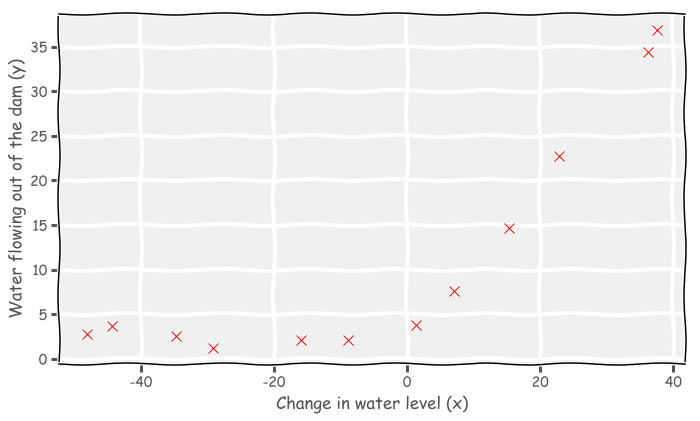

In [82]:
#Visualizing dataset

plt.figure(figsize=(10, 6))
plt.grid(True)
plt.plot(X, y, 'rx', markersize=10, linewidth=1.5)
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');

In [83]:
def linearRegCostFunction(theta, X, y, l):
    theta = theta.reshape(theta.size, 1)
    
    J = 1/(2*m) * (X @ theta - y).T @ (X @ theta - y) + \
        l/(2*m) * (theta[1:].T @ theta[1:])
        
    grad = 1/m * X.T @ (X @ theta - y)
    grad[1:] = grad[1:] + l/m * theta[1:]
    
    return np.float64(J), np.ndarray.flatten(grad)

J, grad = linearRegCostFunction(theta_init, np.c_[np.ones((m, 1)), X], y, 1);

print('Cost at theta = [1, 1]: {}\n'.format(J))
print('Gradient at theta = [1, 1]: \n{}'.format(grad))

Cost at theta = [1, 1]: 303.9931922202643

Gradient at theta = [1, 1]: 
[ -15.303  598.251]


In [84]:
# Training linear regression
def trainLinearReg(X, y, l):
    theta_init = np.zeros((X.shape[1], 1))
    res = minimize(linearRegCostFunction,
               x0=theta_init,
               args=(X, y, l),
               method='CG',
               jac=True,
               options={'maxiter':200})
    return res['x']
theta = trainLinearReg(np.c_[np.ones((m, 1)), X], y, l)

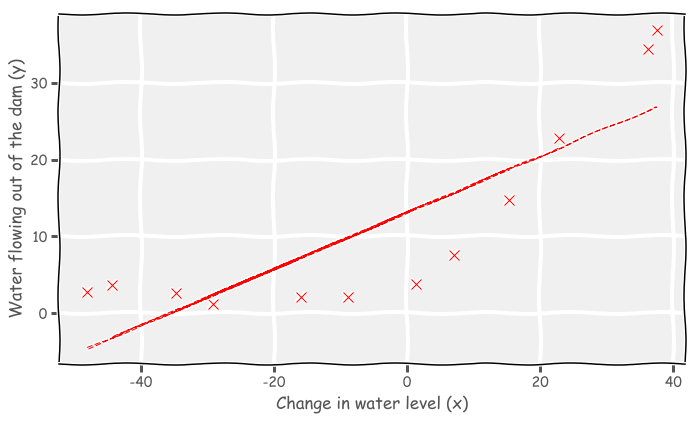

In [85]:
# Plot linear regression line

plt.figure(figsize=(10, 6))

plt.plot(X, y, 'rx', markersize=10, linewidth=1.5)
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');

plt.plot(X, np.c_[np.ones((m, 1)), X] @ theta, '--r', linewidth=1)
plt.grid(True)
plt.show()

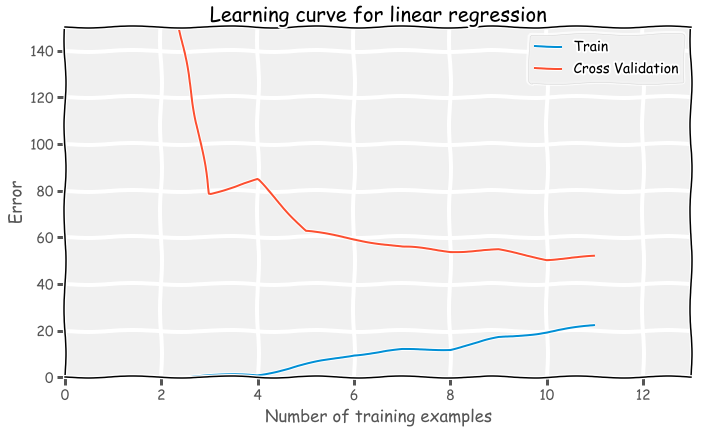

In [86]:
# Plotting learning curve

def learningCurve(X, y, Xval, yval, l):
    m, n = X.shape
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in range(m):
        theta = trainLinearReg(X[:i, :], y[:i], l)
        error_train[i], _ = linearRegCostFunction(theta, X[:i, :], y[:i], 0)
        error_val[i], _ = linearRegCostFunction(theta, Xval, yval, 0)
    return error_train, error_val

plt.figure(figsize=(10, 6))

l=0
error_train, error_val = learningCurve(np.c_[np.ones((m, 1)), X],
                                       y,
                                       np.c_[np.ones((Xval.shape[0], 1)), Xval],
                                       yval, l)

plt.plot(np.arange(0, m), error_train, label='Train')
plt.plot(np.arange(0, m), error_val, label='Cross Validation')

plt.title('Learning curve for linear regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0,13,0,150])
plt.grid(True)

plt.legend()

plt.show()

In [87]:
# Polynomial Regression

# Create polynomial features
def polyFeatures(X, deg):
    """Converts features X into polynomial features of degree deg"""
    return np.power(X, np.arange(deg)+1)

def featureNormalize(X):
    """Normalizes features X"""
    mu = X.mean(axis=0)
    X_norm = X - mu # numpy takes care of array broadcasting
    
    sigma = X.std(axis=0)
    X_norm = X_norm / sigma
    return X_norm, mu, sigma
deg = 8

X_poly = polyFeatures(X, deg)
X_poly, mu, sigma = featureNormalize(X_poly)
X_poly = np.c_[np.ones((m, 1)), X_poly] # add ones

# Map X_poly_test and normalize (using mu and sigma)
X_poly_test = polyFeatures(Xtest, deg)
X_poly_test = np.c_[np.ones((len(X_poly_test), 1)), (X_poly_test - mu) / sigma]

# Map X_poly_val and normalize (using mu and sigma)
X_poly_val = polyFeatures(Xval, deg)
X_poly_val = np.c_[np.ones((len(X_poly_val), 1)), (X_poly_val - mu) / sigma]

In [88]:
def plotFit(x_min, x_max, mu, sigma, theta, p):
    """Plots an already learned polynomial regression fit"""
    X = np.arange(x_min-15, x_max+25, 0.5).reshape((-1, 1))
    X_poly = polyFeatures(X, p)
    X_poly = (X_poly - mu)/sigma
    X_poly = np.c_[np.ones((X.shape[0], 1)), X_poly]

    plt.plot(X, X_poly @ theta, '--', linewidth=2)

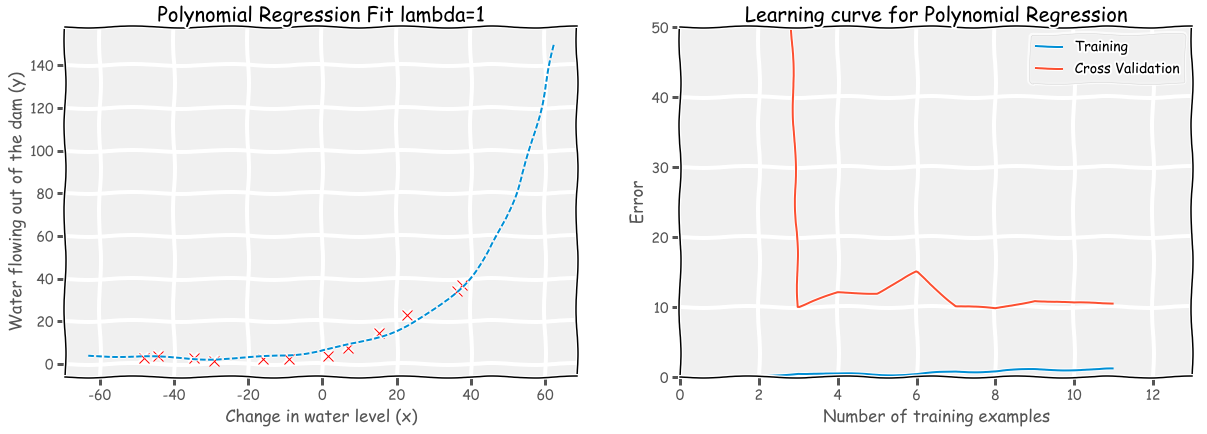

In [95]:
# Learning curve for Polynomial Regression
fig = plt.figure(figsize=(18, 6))

ax1 = fig.add_subplot(1, 2, 1)

l = 1
theta_init = np.zeros((X_poly.shape[1], 1))
theta = trainLinearReg(X_poly, y, l)

plt.plot(X, y, 'rx', markersize=10, linewidth=1.5)
plt.xlabel('Change in water level (x)');
plt.ylabel('Water flowing out of the dam (y)');
plt.title('Polynomial Regression Fit lambda={}'.format(l))
plotFit(X.min(), X.max(), mu, sigma, theta, deg)
plt.grid(True)

ax2 = fig.add_subplot(1, 2, 2)

# Numbers
error_train, error_val = learningCurve(X_poly, y, X_poly_val, yval, l)

# Plotting
plt.plot(np.arange(m), error_train, label='Training')
plt.plot(np.arange(m), error_val, label='Cross Validation')

plt.title('Learning curve for Polynomial Regression')
plt.xlabel('Number of training examples')
plt.ylabel('Error')
plt.axis([0,13,0,50])
plt.legend()
plt.grid(True)

plt.show()

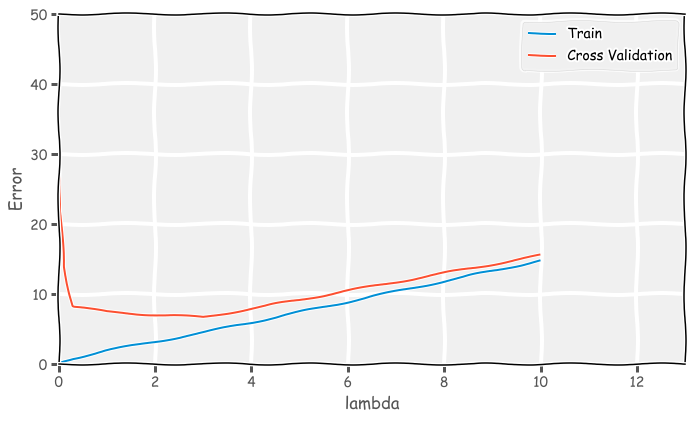

In [92]:
def validationCurve(X, y, Xval, yval):
    l_vec = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
    
    error_train = np.zeros((len(l_vec), 1))
    error_val = np.zeros((len(l_vec), 1))
    
    for i in range(len(l_vec)):
        l = l_vec[i]
        theta = trainLinearReg(X, y, l)
        
        error_train[i] = linearRegCostFunction(theta, X, y, 0)[0]
        error_val[i] = linearRegCostFunction(theta, Xval, yval, 0)[0]
    return l_vec, error_train, error_val

l_vec, error_train, error_val = validationCurve(X_poly, y, X_poly_val, yval)

plt.figure(figsize=(10, 6))

plt.plot(l_vec, error_train, label='Train')
plt.plot(l_vec, error_val, label='Cross Validation')
plt.xlabel('lambda')
plt.ylabel('Error')
plt.axis([0, 13, 0, 50])
plt.grid(True)

plt.legend()

In [93]:
# Compute test error for lambda = 3
l = 3
theta = trainLinearReg(X_poly, y, l)
test_error, _ = linearRegCostFunction(theta, X_poly_test, ytest, 0)
print('Lambda: {0}\nTest Error: {1:.3g}'.format(l, test_error))

Lambda: 3
Test Error: 6.25


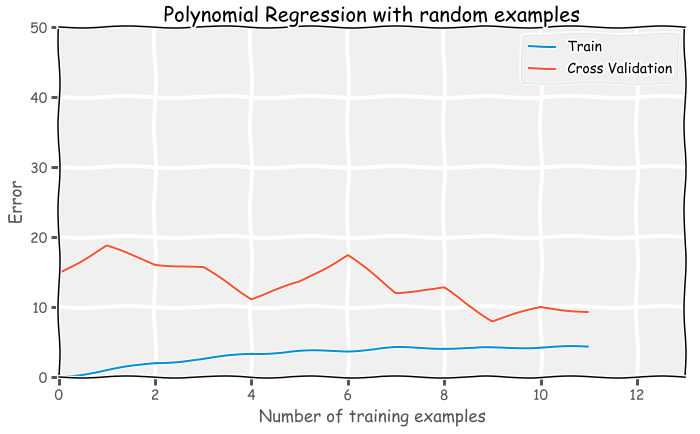

In [96]:
# Evaluating randomly selected examples for polynomial regression 
def randomCurve(X, y, Xval, yval, l, num_iterations):
    m = X.shape[0]
    m_val = Xval.shape[0]
    
    error_train = np.zeros((m, 1))
    error_val = np.zeros((m, 1))
    
    for i in range(m):
        avg_train = 0
        avg_val = 0
        for n in range(num_iterations):
            # Train error
            index = np.random.choice(m, i+1)
            Xrand = X[index]
            yrand = y[index]
            
            theta = trainLinearReg(Xrand, yrand, l)
            avg_train = avg_train + linearRegCostFunction(theta, Xrand, yrand, 0)[0]
            
            index = np.random.choice(m_val, i+1)
            Xval_rand = Xval[index]
            yval_rand = yval[index]
            
            avg_val = avg_val + linearRegCostFunction(theta, Xval_rand, yval_rand, 0)[0]
        error_train[i] = avg_train / num_iterations
        error_val[i] = avg_val / num_iterations
    return error_train, error_val

l = 3
num_iterations = 50

error_train, error_val = randomCurve(X_poly, y, X_poly_val, yval, l, num_iterations)

# Plot error and lambda
plt.figure(figsize=(10,6))

plt.plot(np.arange(m), error_train, label='Train')
plt.plot(np.arange(m), error_val, label='Cross Validation')

plt.xlabel('Number of training examples');
plt.ylabel('Error');
plt.title('Polynomial Regression with random examples')
plt.axis([0, 13, 0, 50])
plt.legend();
plt.grid(True)
plt.show()